In [1]:
#Задание 1
#Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
from tqdm import tqdm
import matplotlib.colors as mcolors

In [3]:
df1 = pd.read_csv('problem1-reg_data.csv', sep = ';') #подгрузим наши данные из папки shared
df2 = pd.read_csv('problem1-auth_data.csv', sep = ';')

In [4]:
df1 #Посмотрим на вид имеющихся данных. Мы видим, что они представлены в формате Unix time

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [5]:
df2

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [6]:
df1['reg_ts'] = pd.to_datetime(df1.reg_ts, unit='s')#Переведем наши данные в более читаемый вид
df1['reg_ts'] = df1.reg_ts.astype('datetime64[D]') #Приведем данные к виду гггг-мм-дд

In [7]:
df1

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5
...,...,...
999995,2020-09-23,1110618
999996,2020-09-23,1110619
999997,2020-09-23,1110620
999998,2020-09-23,1110621


In [8]:
df2['auth_ts'] = pd.to_datetime(df2.auth_ts, unit='s')
df2['auth_ts'] = df2.auth_ts.astype('datetime64[D]')

In [9]:
df2

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2
...,...,...
9601008,2020-09-23,1110618
9601009,2020-09-23,1110619
9601010,2020-09-23,1110620
9601011,2020-09-23,1110621


In [10]:
df1.duplicated().sum() #Проверим налиие дубликатов в каждом из датафреймов

0

In [11]:
df2.duplicated().sum()

0

In [12]:
df1.isna().sum() #Проверим на недостающие значения


reg_ts    0
uid       0
dtype: int64

In [13]:
df2.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [14]:
df3 = df1.merge(df2, how='inner', on='uid') #Объединим 2 датафрейма

In [15]:
df3

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05
...,...,...,...
9601008,2020-09-23,1110618,2020-09-23
9601009,2020-09-23,1110619,2020-09-23
9601010,2020-09-23,1110620,2020-09-23
9601011,2020-09-23,1110621,2020-09-23


In [16]:
df3 = df3[['uid', 'reg_ts', 'auth_ts']]

In [17]:
df3

,uid,reg_ts,auth_ts
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05
...,...,...,...
9601008,1110618,2020-09-23,2020-09-23
9601009,1110619,2020-09-23,2020-09-23
9601010,1110620,2020-09-23,2020-09-23
9601011,1110621,2020-09-23,2020-09-23


In [18]:
# df3-датафрейм, start-дата начала ретеншина гггг-мм-дд, days-n-ый день с момента своего прихода
def retention(df3, start, ndays):  
    """
    Конец расчетного периода
    Оставим данные только от начала и до конца необходимого периода
    Построение телповой карты
    Создадим сводную таблицу, где строки - даты регистрации, колонки - разницы в днях, значения - количество уникальных игроков
    Для определения наших значений разделим столбцы на первый
    Визуализируем полученные данные
    """

    end = start + pd.Timedelta(days=ndays)
    
    df3 = df3.query('reg_ts >= @start and auth_ts <= @end')\
        .groupby(['reg_ts', 'auth_ts'], as_index=False)\
        .agg(gamers=('uid', 'nunique'))
    df3['days'] = (df3['auth_ts'] - df3['reg_ts']).dt.days 
    
    retention = df3.pivot_table(index='reg_ts', columns='days', values='gamers')
    cohorts_size = retention.iloc[:,0]
    retention = retention.divide(retention.iloc[:, 0], axis=0)
    
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharey=True, gridspec_kw={'width_ratios': [1, 10]})
    
    sns.heatmap(retention, fmt='.1%', annot=True, vmin=0.0, vmax=0.1, cmap="Greens", ax=ax[1])
    
    ax[1].set_title('retention', fontsize=15)
    ax[1].set(xlabel='Период', ylabel='')
    
    cohorts_size2 = pd.DataFrame(cohorts_size).rename(columns={0: 'cohort_size'})
    sns.heatmap(cohorts_size2, annot=True, cbar=False, fmt='g', cmap="Greens",ax=ax[0])
    ax[0].set_yticklabels(retention.index.strftime('%Y-%m-%d'), fontsize=10)
    ax[0].set(ylabel='Даты регистрации')
    fig.tight_layout()




In [19]:
start = pd.to_datetime(input()) # Задаём дату начала
ndays = int(input()) #Задаём n-ый день


2018-06-10
15


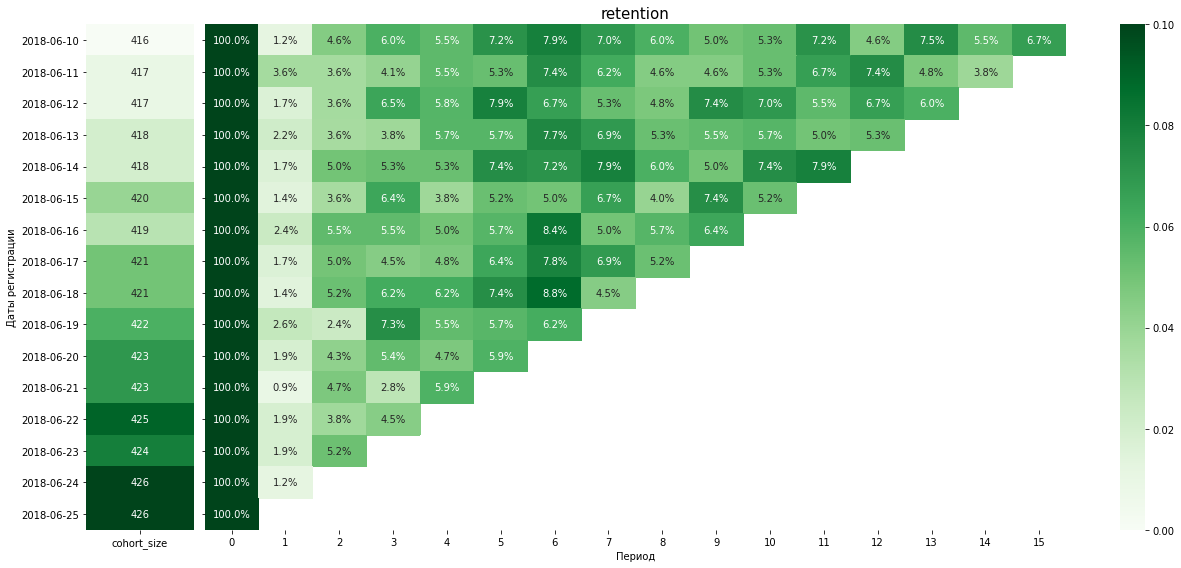

In [20]:
retention(df3, start, ndays)

In [21]:
print (retention.__doc__)


    Конец расчетного периода
    Оставим данные только от начала и до конца необходимого периода
    Построение телповой карты
    Создадим сводную таблицу, где строки - даты регистрации, колонки - разницы в днях, значения - количество уникальных игроков
    Для определения наших значений разделим столбцы на первый
    Визуализируем полученные данные
    
